In [1]:
import pandas as pd
import numpy as np
import h5py
import torch
import torch.nn as nn
import random
import sys
import os

#trying to ensure reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [2]:
# Setting path to load util functions
from pathlib import Path
parent_dir = Path.cwd().parents[1]
sys.path.append(os.path.abspath(parent_dir))

In [3]:
experiment_num = 25

In [4]:
#Loading data
with h5py.File('../../data/3d_array/mod_train_data_3d_h5.h5', 'r') as f:
    train_X = f['train_data_3d'][:]
with h5py.File('../../data/3d_array/mod_val_data_3d_h5.h5', 'r') as f:
    val_X = f['val_data_3d'][:]
with h5py.File('../../data/3d_array/mod_test_data_3d_h5.h5', 'r') as f:
    test_X = f['test_data_3d'][:]

train_y = pd.read_parquet('../../data/3d_array/train_targets.parquet')
val_y = pd.read_parquet('../../data/3d_array/val_targets.parquet')
test_y = pd.read_parquet('../../data/3d_array/test_targets.parquet')

In [5]:
train_X = np.nan_to_num(train_X, nan=0.0)
val_X = np.nan_to_num(val_X, nan=0.0)
test_X = np.nan_to_num(test_X, nan=0.0)

In [6]:
train_y['end_of_month'].value_counts()

end_of_month
2018-03-31    289115
Name: count, dtype: int64

In [7]:
train_y = train_y[train_y['end_of_month'].isin(['2018-03-31'])]
val_y = val_y[val_y['end_of_month'].isin(['2018-03-31'])]
test_y = test_y[test_y['end_of_month'].isin(['2018-03-31'])]

C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_26888\847019464.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  train_y = train_y[train_y['end_of_month'].isin(['2018-03-31'])]
C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_26888\847019464.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  val_y = val_y[val_y['end_of_month'].isin(['2018-03-31'])]
C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_26888\847019464.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be c

In [8]:
train_y.sort_values(by=['customer_ID'])

,customer_ID,end_of_month,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-31,0
1,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-03-31,0
2,000084e5023181993c2e1b665ac88dbb1ce9ef621ec537...,2018-03-31,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2018-03-31,0
4,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2018-03-31,1
...,...,...,...
289110,fffe3ec7cdbc1caac845c884b389ed347bfc1da9d09731...,2018-03-31,1
289111,fffef3305f19a11fb6c15f4ebe9be1bd664540e57c0a6a...,2018-03-31,0
289112,ffff39cc22a375d07369980d02d617883dd28ad81a6aa3...,2018-03-31,0
289113,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,2018-03-31,0


In [9]:
train_X.shape, train_y.shape

((289115, 13, 86), (289115, 3))

In [10]:
val_X.shape, val_y.shape

((32124, 13, 86), (32124, 3))

In [11]:
class ParallelConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 5, 7], dropout_rate=0.2):
        """
        Parallel Convolutional Block that processes input through multiple convolutional paths
        with different kernel sizes and concatenates the results.
        
        Args:
            in_channels: Number of input channels
            out_channels: Number of output channels
            kernel_sizes: List of kernel sizes for parallel convolutions
            dropout_rate: Dropout probability
        """
        super(ParallelConvBlock, self).__init__()
        
        self.n_paths = len(kernel_sizes)
        # Calculate channels per path
        path_channels = out_channels // self.n_paths
        
        # Create parallel convolutional paths
        self.paths = nn.ModuleList()
        for k_size in kernel_sizes:
            padding = k_size // 2  # Same padding to maintain sequence length
            path = nn.Sequential(
                nn.Conv1d(in_channels, path_channels, kernel_size=k_size, padding=padding),
                nn.BatchNorm1d(path_channels),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
            self.paths.append(path)
            
        # Projection layer to ensure output has exactly out_channels
        self.projection = nn.Sequential(
            nn.Conv1d(path_channels * self.n_paths, out_channels, kernel_size=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        # Process input through parallel paths
        outputs = [path(x) for path in self.paths]
        
        # Concatenate along channel dimension
        # print(f"Outputs shape before concatenation: {[out.shape for out in outputs]}")
        x = torch.cat(outputs, dim=1)
        
        # Apply projection to get final output
        x = self.projection(x)
        
        return x

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, pool=True, dropout=0.3):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2) if pool else None
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        if self.pool:
            x = self.pool(x)
        x = self.dropout(x)
        return x

In [13]:
class ConvLSTMModel(nn.Module):
    def __init__(self, input_size, lstm_hidden_size=64, num_lstm_layers=1, output_size=1):
        """
        Args:
            input_size (int): Number of features in the input sequence (feature dimension).
            lstm_hidden_size (int): Hidden size for the LSTM layer.
            num_lstm_layers (int): Number of layers for the LSTM.
            output_size (int): Size of the final output (e.g., 1 for binary classification).
        """
        super(ConvLSTMModel, self).__init__()

        self.input_size = input_size
        self.lstm_hidden_size = lstm_hidden_size

        # --- CNN Path ---
        # First convolutional block (Parallel)
        # Input channels = input_size (features)
        cnn_out_channels_1 = 100
        self.parallel_conv = ParallelConvBlock(input_size, cnn_out_channels_1, kernel_sizes=[3, 5, 7, 9], dropout_rate=0.2)

        # Second convolutional block
        cnn_out_channels_2 = 64
        self.block2 = ConvBlock(cnn_out_channels_1, cnn_out_channels_2, dropout=0.2)

        # Third convolutional block
        self.cnn_final_channels = 32
        self.block3 = ConvBlock(cnn_out_channels_2, self.cnn_final_channels, pool=False, dropout=0.2) # No pooling in the last block

        # Global pooling for CNN path
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        # --- LSTM Path ---
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=lstm_hidden_size,
                            num_layers=num_lstm_layers,
                            batch_first=True, # Crucial: input shape (batch, seq_len, features)
                            bidirectional=False) # Set to True if needed, adjust feature concatenation below

        # --- Combined Path ---
        # Calculate the combined feature size after CNN pooling and LSTM
        combined_features = self.cnn_final_channels + lstm_hidden_size # Add *2 if bidirectional LSTM

        # Fully connected layers
        self.fc1 = nn.Linear(combined_features, 16) # Input size adjusted
        self.relu_fc1 = nn.ReLU()
        self.dropout_fc1 = nn.Dropout(0.3) # Added dropout for FC layer
        self.fc2 = nn.Linear(16, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Input shape: batch_size x time_steps x features

        # --- CNN Path ---
        # For Conv1D: convert to batch_size x features(channels) x time_steps
        x_cnn = x.permute(0, 2, 1)
        # Pass through convolutional blocks
        cnn_out = self.parallel_conv(x_cnn)
        cnn_out = self.block2(cnn_out)
        cnn_out = self.block3(cnn_out)
        # Global pooling to get fixed-size representation for CNN path
        cnn_pooled = self.global_avg_pool(cnn_out)
        cnn_features = cnn_pooled.view(cnn_pooled.size(0), -1) # Flatten: batch_size x cnn_final_channels

        # --- LSTM Path ---
        # Input shape expected by LSTM (batch_first=True): batch_size x time_steps x features
        # No permutation needed for LSTM path if input is already in this format
        lstm_out, (h_n, c_n) = self.lstm(x)
        # We typically use the last hidden state
        # h_n shape: (num_layers * num_directions, batch_size, lstm_hidden_size)
        # Get the hidden state of the last layer
        lstm_features = h_n[-1] # Shape: batch_size x lstm_hidden_size (if not bidirectional)
        # If bidirectional: h_n shape is (num_layers*2, batch, hidden_size)
        # You might want to concatenate the last forward and backward hidden states:
        # lstm_features = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1) # If bidirectional

        # --- Concatenate Features ---
        combined_features = torch.cat((cnn_features, lstm_features), dim=1)

        # --- Fully Connected Layers ---
        x = self.fc1(combined_features)
        x = self.relu_fc1(x)
        x = self.dropout_fc1(x)
        x = self.fc2(x)

        # Output probability
        return self.sigmoid(x)

In [14]:
# Initialize the ConvModel
input_size = train_X.shape[2]  # Number of features
output_size = 1  # Binary classification
lstm_hidden_size = 128
num_lstm_layers = 1

# Create model instance
model = ConvLSTMModel(input_size=input_size, output_size=output_size, lstm_hidden_size=lstm_hidden_size, num_lstm_layers=num_lstm_layers)
print(f"Model initialized with input_size={input_size}, output_size={output_size}")

Model initialized with input_size=86, output_size=1


In [15]:
batch_size = 2048
from torchinfo import summary
summary(model, input_size=(batch_size, train_X.shape[1], train_X.shape[2]), device='cpu',
        col_names=["input_size", "kernel_size","output_size", "num_params"], depth = 1)

Layer (type:depth-idx)                   Input Shape               Kernel Shape              Output Shape              Param #
ConvLSTMModel                            [2048, 13, 86]            --                        [2048, 1]                 --
├─ParallelConvBlock: 1-1                 [2048, 86, 13]            --                        [2048, 100, 13]           62,200
├─ConvBlock: 1-2                         [2048, 100, 13]           --                        [2048, 64, 6]             19,392
├─ConvBlock: 1-3                         [2048, 64, 6]             --                        [2048, 32, 6]             6,240
├─AdaptiveAvgPool1d: 1-4                 [2048, 32, 6]             --                        [2048, 32, 1]             --
├─LSTM: 1-5                              [2048, 13, 86]            --                        [2048, 13, 128]           110,592
├─Linear: 1-6                            [2048, 160]               --                        [2048, 16]                2,576



(process:28408): Pango-WARNING **: 10:55:33.945: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


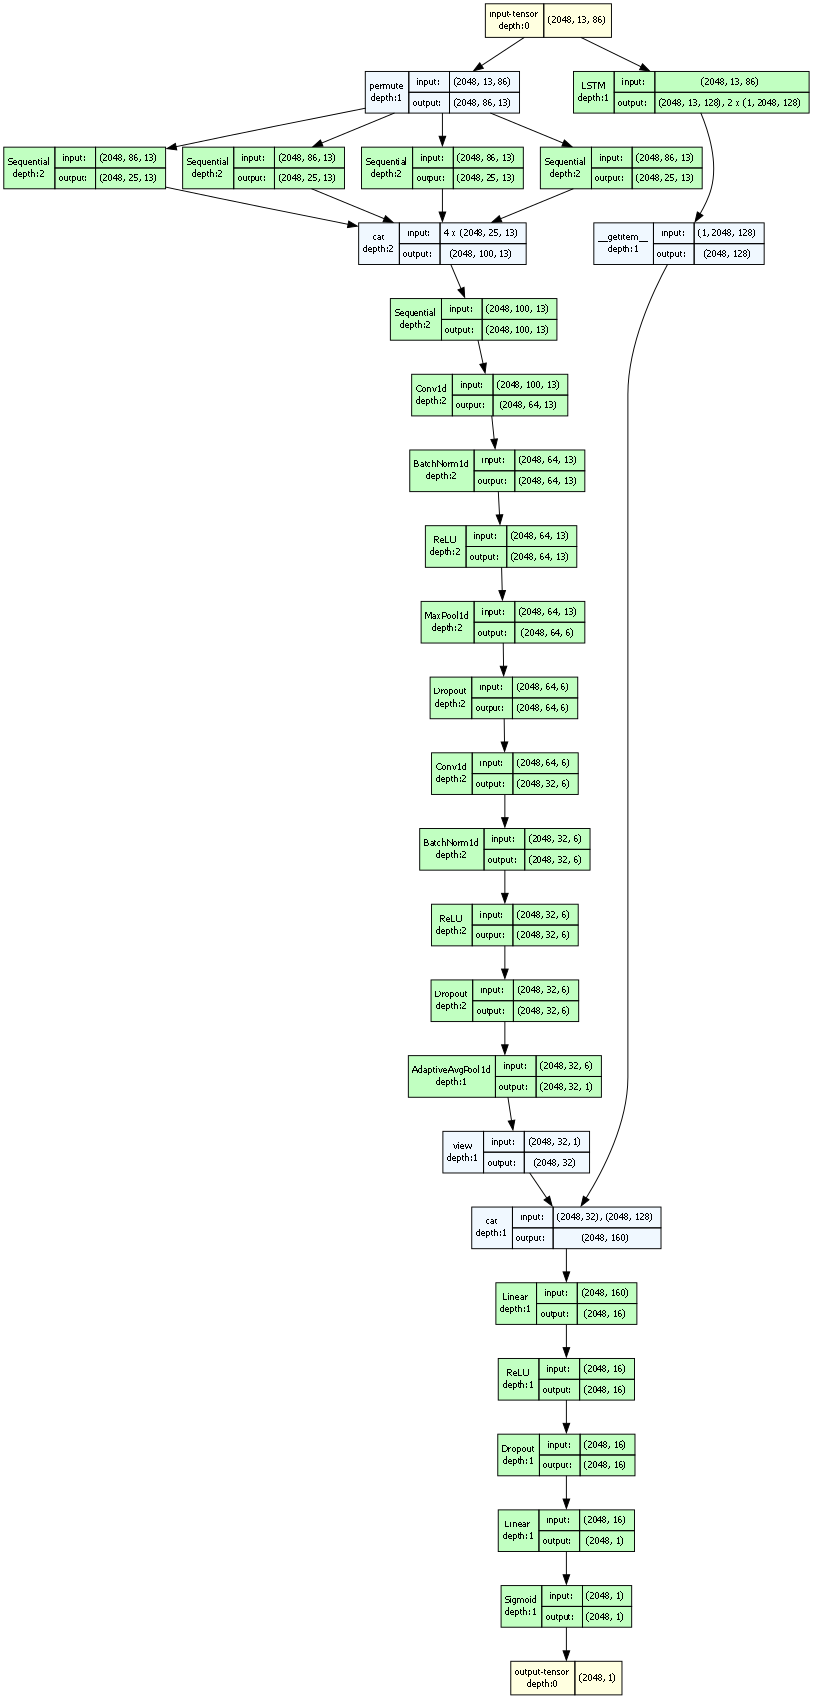

In [19]:
import graphviz
graphviz.set_jupyter_format('png')
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(batch_size, train_X.shape[1], train_X.shape[2]), device='meta', depth = 2)
model_graph.visual_graph

In [19]:
from torch.utils.data import Dataset, DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets):
        """
        Args:
            data: numpy array of shape (num_ids, time_steps, features)
            targets: numpy array of shape (num_ids,)
        """
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets).unsqueeze(1)  # Add dimension for output
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [20]:
train_dataset = TimeSeriesDataset(train_X, train_y['target'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [21]:
val_dataset = TimeSeriesDataset(val_X, val_y['target'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [22]:
test_dataset = TimeSeriesDataset(test_X, test_y['target'].values)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
train_dataset.__getitem__(0)[0].shape, train_dataset.__getitem__(0)[1]

(torch.Size([13, 86]), tensor([0.]))

In [24]:
val_dataset.__getitem__(0)[0].shape, val_dataset.__getitem__(0)[1]

(torch.Size([13, 86]), tensor([1.]))

In [25]:
import torch.optim as optim
# Import the learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score
import numpy as np # Needed for checking NaN if AUC fails
import time
import copy
from tqdm.auto import tqdm

# --- Define Loss Function and Optimizer ---
# NOTE: Ensure your model's output layer includes a Sigmoid activation for BCELoss
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Initial learning rate

# --- Learning Rate Scheduler ---
lr_patience = 5 # Number of epochs with no improvement after which learning rate will be reduced
lr_factor = 0.1 # Factor by which the learning rate will be reduced. new_lr = lr * factor
scheduler = ReduceLROnPlateau(optimizer,
                              mode='min',      # Reduce LR when the monitored quantity stops decreasing
                              factor=lr_factor,
                              patience=lr_patience,
                              verbose=True,    # Print a message when LR is reduced
                              threshold=0.0001, # Threshold for measuring the new optimum
                              min_lr=1e-6)     # Lower bound on the learning rate

# --- Training parameters ---
num_epochs = 100
early_stopping_patience = 20  # Number of epochs for early stopping (can be same or different from lr_patience)

# --- Initialize variables for early stopping ---
best_val_loss = float('inf')
best_val_auc = 0.0
# Correctly use state_dict() for saving/loading model weights
best_model_wts = copy.deepcopy(model.state_dict())
no_improve_epochs = 0 # Counter for early stopping

# --- For tracking metrics ---
train_losses = []
val_losses = []
val_aucs = []

# --- Move model to device ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Training on {device}")
print(f"Initial Learning Rate: {optimizer.param_groups[0]['lr']}")
print(f"LR Scheduler Patience: {lr_patience}, Factor: {lr_factor}")
print(f"Early Stopping Patience: {early_stopping_patience}")

start_time = time.time()

# --- Training loop ---
for epoch in range(num_epochs):
    # --- Training phase ---
    model.train()
    running_loss = 0.0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for inputs, labels in train_pbar:
        # Ensure labels are float for BCELoss
        inputs, labels = inputs.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs) # Should be probabilities (output of Sigmoid)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        train_pbar.set_postfix({'loss': loss.item()})

    epoch_train_loss = running_loss / len(train_dataset) # Use len(train_dataset) for average
    train_losses.append(epoch_train_loss)

    # --- Validation phase ---
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]", leave=False)
    with torch.no_grad():
        for inputs, labels in val_pbar:
            # Ensure labels are float for BCELoss
            inputs, labels = inputs.to(device), labels.to(device).float()

            outputs = model(inputs) # Probabilities
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            val_pbar.set_postfix({'loss': loss.item()})

    epoch_val_loss = running_loss / len(val_dataset) # Use len(val_dataset) for average
    val_losses.append(epoch_val_loss)

    # Flatten potentially nested lists/arrays if output_size=1
    try:
        all_preds_flat = [p[0] for p in all_preds]
        all_labels_flat = [l[0] for l in all_labels]
    except IndexError: # Handle cases where outputs/labels might already be flat
        all_preds_flat = all_preds
        all_labels_flat = all_labels

    # Calculate AUC
    try:
        epoch_val_auc = roc_auc_score(all_labels_flat, all_preds_flat)
        val_aucs.append(epoch_val_auc)
    except ValueError as e:
        print(f"Could not calculate AUC: {e}. Skipping AUC for this epoch.")
        epoch_val_auc = float('nan') # Assign NaN or handle as appropriate
        val_aucs.append(epoch_val_auc)


    # --- Learning Rate Scheduler Step ---
    # Pass the validation loss to the scheduler
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(epoch_val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr < current_lr:
        print(f"Learning rate reduced from {current_lr} to {new_lr}")


    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, "
          f"Val AUC: {epoch_val_auc:.4f}, "
          f"LR: {optimizer.param_groups[0]['lr']:.1e}") # Display current LR

    # Check if this is the best model (based on validation loss)
    if epoch_val_loss < best_val_loss - scheduler.threshold: # Use scheduler's threshold
        print(f"Validation loss improved ({best_val_loss:.4f} --> {epoch_val_loss:.4f}). Saving model...")
        best_val_loss = epoch_val_loss
        if not np.isnan(epoch_val_auc): # Only update best AUC if it's valid
            best_val_auc = epoch_val_auc
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improve_epochs = 0 # Reset early stopping counter
    else:
        no_improve_epochs += 1
        print(f"Validation loss did not improve for {no_improve_epochs} epoch(s).")

    # Early stopping check (using early_stopping_patience)
    if no_improve_epochs >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs due to no improvement for {early_stopping_patience} epochs.")
        break

# --- Training complete ---
time_elapsed = time.time() - start_time
print(f"Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
print(f"Best val loss: {best_val_loss:.4f}, Best val AUC at that point: {best_val_auc:.4f}")

# Load best model weights
model.load_state_dict(best_model_wts)
print("Best model weights loaded.")

Training on cuda:0
Initial Learning Rate: 0.001
LR Scheduler Patience: 5, Factor: 0.1
Early Stopping Patience: 20


c:\Users\vaseekaranv\AppData\Local\anaconda3\envs\nibm_dl\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 1/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/100 - Train Loss: 0.3324, Val Loss: 0.2492, Val AUC: 0.9499, LR: 1.0e-03
Validation loss improved (inf --> 0.2492). Saving model...


Epoch 2/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 2/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/100 - Train Loss: 0.2574, Val Loss: 0.2448, Val AUC: 0.9516, LR: 1.0e-03
Validation loss improved (0.2492 --> 0.2448). Saving model...


Epoch 3/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 3/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/100 - Train Loss: 0.2521, Val Loss: 0.2518, Val AUC: 0.9519, LR: 1.0e-03
Validation loss did not improve for 1 epoch(s).


Epoch 4/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 4/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/100 - Train Loss: 0.2484, Val Loss: 0.2430, Val AUC: 0.9531, LR: 1.0e-03
Validation loss improved (0.2448 --> 0.2430). Saving model...


Epoch 5/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 5/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/100 - Train Loss: 0.2460, Val Loss: 0.2388, Val AUC: 0.9534, LR: 1.0e-03
Validation loss improved (0.2430 --> 0.2388). Saving model...


Epoch 6/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 6/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/100 - Train Loss: 0.2444, Val Loss: 0.2433, Val AUC: 0.9531, LR: 1.0e-03
Validation loss did not improve for 1 epoch(s).


Epoch 7/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 7/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/100 - Train Loss: 0.2430, Val Loss: 0.2393, Val AUC: 0.9532, LR: 1.0e-03
Validation loss did not improve for 2 epoch(s).


Epoch 8/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 8/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/100 - Train Loss: 0.2418, Val Loss: 0.2389, Val AUC: 0.9535, LR: 1.0e-03
Validation loss did not improve for 3 epoch(s).


Epoch 9/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 9/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/100 - Train Loss: 0.2406, Val Loss: 0.2390, Val AUC: 0.9532, LR: 1.0e-03
Validation loss did not improve for 4 epoch(s).


Epoch 10/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 10/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.2391, Val Loss: 0.2408, Val AUC: 0.9532, LR: 1.0e-03
Validation loss did not improve for 5 epoch(s).


Epoch 11/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 11/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Learning rate reduced from 0.001 to 0.0001
Epoch 11/100 - Train Loss: 0.2384, Val Loss: 0.2399, Val AUC: 0.9534, LR: 1.0e-04
Validation loss did not improve for 6 epoch(s).


Epoch 12/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 12/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12/100 - Train Loss: 0.2345, Val Loss: 0.2366, Val AUC: 0.9545, LR: 1.0e-04
Validation loss improved (0.2388 --> 0.2366). Saving model...


Epoch 13/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 13/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13/100 - Train Loss: 0.2336, Val Loss: 0.2424, Val AUC: 0.9532, LR: 1.0e-04
Validation loss did not improve for 1 epoch(s).


Epoch 14/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 14/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14/100 - Train Loss: 0.2327, Val Loss: 0.2368, Val AUC: 0.9544, LR: 1.0e-04
Validation loss did not improve for 2 epoch(s).


Epoch 15/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 15/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15/100 - Train Loss: 0.2323, Val Loss: 0.2372, Val AUC: 0.9543, LR: 1.0e-04
Validation loss did not improve for 3 epoch(s).


Epoch 16/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 16/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16/100 - Train Loss: 0.2320, Val Loss: 0.2372, Val AUC: 0.9543, LR: 1.0e-04
Validation loss did not improve for 4 epoch(s).


Epoch 17/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 17/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17/100 - Train Loss: 0.2317, Val Loss: 0.2372, Val AUC: 0.9543, LR: 1.0e-04
Validation loss did not improve for 5 epoch(s).


Epoch 18/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 18/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Learning rate reduced from 0.0001 to 1e-05
Epoch 18/100 - Train Loss: 0.2317, Val Loss: 0.2381, Val AUC: 0.9541, LR: 1.0e-05
Validation loss did not improve for 6 epoch(s).


Epoch 19/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 19/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19/100 - Train Loss: 0.2310, Val Loss: 0.2373, Val AUC: 0.9543, LR: 1.0e-05
Validation loss did not improve for 7 epoch(s).


Epoch 20/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 20/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.2309, Val Loss: 0.2379, Val AUC: 0.9539, LR: 1.0e-05
Validation loss did not improve for 8 epoch(s).


Epoch 21/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 21/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 21/100 - Train Loss: 0.2311, Val Loss: 0.2387, Val AUC: 0.9536, LR: 1.0e-05
Validation loss did not improve for 9 epoch(s).


Epoch 22/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 22/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 22/100 - Train Loss: 0.2305, Val Loss: 0.2404, Val AUC: 0.9532, LR: 1.0e-05
Validation loss did not improve for 10 epoch(s).


Epoch 23/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 23/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 23/100 - Train Loss: 0.2307, Val Loss: 0.2374, Val AUC: 0.9541, LR: 1.0e-05
Validation loss did not improve for 11 epoch(s).


Epoch 24/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 24/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Learning rate reduced from 1e-05 to 1.0000000000000002e-06
Epoch 24/100 - Train Loss: 0.2302, Val Loss: 0.2397, Val AUC: 0.9534, LR: 1.0e-06
Validation loss did not improve for 12 epoch(s).


Epoch 25/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 25/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 25/100 - Train Loss: 0.2304, Val Loss: 0.2374, Val AUC: 0.9542, LR: 1.0e-06
Validation loss did not improve for 13 epoch(s).


Epoch 26/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 26/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 26/100 - Train Loss: 0.2306, Val Loss: 0.2376, Val AUC: 0.9541, LR: 1.0e-06
Validation loss did not improve for 14 epoch(s).


Epoch 27/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 27/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 27/100 - Train Loss: 0.2304, Val Loss: 0.2377, Val AUC: 0.9540, LR: 1.0e-06
Validation loss did not improve for 15 epoch(s).


Epoch 28/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 28/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 28/100 - Train Loss: 0.2307, Val Loss: 0.2379, Val AUC: 0.9539, LR: 1.0e-06
Validation loss did not improve for 16 epoch(s).


Epoch 29/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 29/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 29/100 - Train Loss: 0.2305, Val Loss: 0.2387, Val AUC: 0.9537, LR: 1.0e-06
Validation loss did not improve for 17 epoch(s).


Epoch 30/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 30/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.2304, Val Loss: 0.2375, Val AUC: 0.9541, LR: 1.0e-06
Validation loss did not improve for 18 epoch(s).


Epoch 31/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 31/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 31/100 - Train Loss: 0.2303, Val Loss: 0.2376, Val AUC: 0.9542, LR: 1.0e-06
Validation loss did not improve for 19 epoch(s).


Epoch 32/100 [Train]:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 32/100 [Valid]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 32/100 - Train Loss: 0.2302, Val Loss: 0.2375, Val AUC: 0.9541, LR: 1.0e-06
Validation loss did not improve for 20 epoch(s).
Early stopping triggered after 32 epochs due to no improvement for 20 epochs.
Training completed in 5m 31s
Best val loss: 0.2366, Best val AUC at that point: 0.9545
Best model weights loaded.


In [26]:
import os

# Save the model weights

# Create directory if it doesn't exist
save_dir = '../../models/deep_learning'
os.makedirs(save_dir, exist_ok=True)

# Save model state dictionary
model_path = os.path.join(save_dir, f'experiment_{experiment_num}.pth')
torch.save(model.state_dict(), model_path)

# Save additional information for later reference
checkpoint_path = os.path.join(save_dir, f'experiment_{experiment_num}.pth')
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}
torch.save(checkpoint, checkpoint_path)

print(f"Model saved to {model_path}")
print(f"Checkpoint saved to {checkpoint_path}")

Model saved to ../../models/deep_learning\experiment_25.pth
Checkpoint saved to ../../models/deep_learning\experiment_25.pth


Validation predictions obtained.
Target Recall: >= 0.9800 for Class 0
Threshold found by Binary Search: 0.7528384
Achieved Recall at Threshold: 0.9800
Classification Report:
              precision    recall  f1-score   support

     Class 0     0.8614    0.9800    0.9169     23806
     Class 1     0.9056    0.5488    0.6834      8318

    accuracy                         0.8684     32124
   macro avg     0.8835    0.7644    0.8002     32124
weighted avg     0.8729    0.8684    0.8564     32124



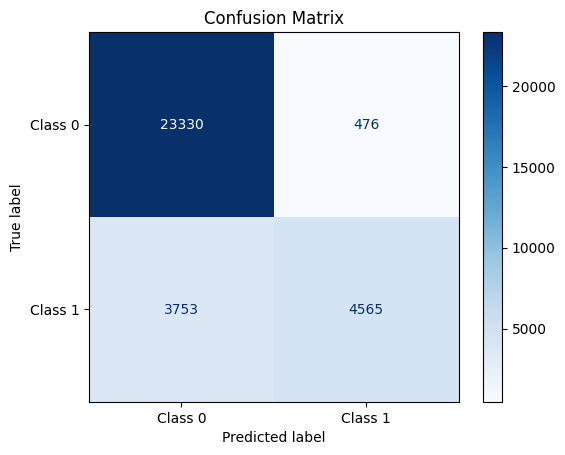

0.7528383731842041

In [27]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize a list to store predictions
val_predictions = []

# Disable gradient computation for inference
with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        val_predictions.extend(outputs.cpu().numpy())

# Flatten the predictions
val_predictions = [p[0] for p in val_predictions]
print("Validation predictions obtained.")

from utils.eval_helpers import evaluate_model_for_recall
evaluate_model_for_recall(target_class=0, desired_recall=0.98, y_true=np.array(all_labels).astype('int'), y_pred_proba=np.array(val_predictions))

In [28]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Set model to evaluation mode
model.eval()

# Check if CUDA is available and move model to the appropriate device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Lists to store predictions and true values
all_preds = []
all_labels = []

# Perform inference without gradient calculation
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Store predictions and labels
        all_preds.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all batches
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Convert predictions to binary (0 or 1) using threshold of 0.5
pred_classes = (all_preds > 0.5).astype(int)
true_classes = all_labels.astype(int)

# Generate classification report

# Print classification report
print("Classification Report:")
print(classification_report(true_classes, pred_classes, digits = 4))

# Calculate and print accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print ROC-AUC score
auc = roc_auc_score(true_classes, all_preds)
print(f"ROC-AUC Score: {auc:.4f}")

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(true_classes, pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0     0.9202    0.9353    0.9276    102026
           1     0.8056    0.7678    0.7862     35648

    accuracy                         0.8919    137674
   macro avg     0.8629    0.8515    0.8569    137674
weighted avg     0.8905    0.8919    0.8910    137674

Accuracy: 0.8919
ROC-AUC Score: 0.9530

Confusion Matrix:
[[95420  6606]
 [ 8279 27369]]


Target Recall: >= 0.9800 for Class 0
Threshold found by Binary Search: 0.7502944
Achieved Recall at Threshold: 0.9800
Classification Report:
              precision    recall  f1-score   support

     Class 0     0.8597    0.9800    0.9159    102026
     Class 1     0.9046    0.5424    0.6782     35648

    accuracy                         0.8667    137674
   macro avg     0.8822    0.7612    0.7971    137674
weighted avg     0.8713    0.8667    0.8544    137674



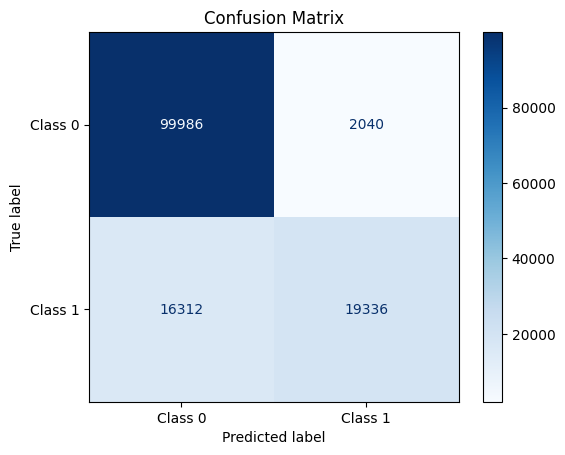

0.7502944469451904

In [29]:
evaluate_model_for_recall(target_class=0, desired_recall=0.98, y_true=true_classes, y_pred_proba=all_preds)